In [1]:
import numpy as np
import pandas as pd

import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
sys.path.append("../../..")


import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso 
from sklearn.decomposition import PCA #USE PCA FOR PCR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import datetime
import math
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Link for NFL Attendance Data: https://docs.google.com/spreadsheets/d/1DRMB5FLC3tdngeurDwps1CS8-6smEZvmq5R-ghjEv5k/edit#gid=0


#Import NFL Attendance Data using Pandas
attendance_df = pd.read_csv('NFL_Data.csv')

#Lots of NaN values, remove values without 'Team'
attendance_df = attendance_df.loc[~attendance_df['Team'].isnull()]

#Import NFL stadium County data, along with Neutral Counties
stadium_county_df = pd.read_csv('Stadium_County.csv',header=1) #Data is a little bit Messy 


#County Covid Rates Provided from NYTIMES Github Database, https://github.com/nytimes/covid-19-data/blob/master/us-counties-2020.csv
county_covid = pd.read_csv('County_Covid_Data.csv')


stadium_county_df['Team '].fillna(method = 'ffill', inplace= True)
stadium_county_df.rename(columns={'Team ': 'Team'}, inplace=True)
county_covid['date'] = pd.to_datetime(county_covid['date'])
county_covid = county_covid.loc[~(county_covid['county'] == 'Unknown')]
county_covid = county_covid.loc[~(county_covid['cases'].isnull())]
county_covid['county'] = county_covid['county'].apply(lambda x: x.lower() if isinstance(x, str) else x)



In [3]:
#We want to fill in state/county Data for cities that don't have stadium counties listed. Go through 1 by 1
no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']
stadium_county_df.loc[stadium_county_df['Team'] == 'Arizona', 'State'] = 'AZ'
stadium_county_df.loc[stadium_county_df['Team'] == 'Chicago', 'State'] = 'IL'

stadium_county_df.loc[stadium_county_df['Team'] == 'Detroit', 'State'] = 'MI'

stadium_county_df.loc[stadium_county_df['Team'] == 'Las Vegas', 'State'] = 'NV'

stadium_county_df.loc[stadium_county_df['Team'] == 'LA Chargers', 'State'] = 'CA'

stadium_county_df.loc[stadium_county_df['Team'] == 'LA Rams', 'State'] = 'CA'

stadium_county_df.loc[stadium_county_df['Team'] == 'Minnesota', 'State'] = 'MN'

stadium_county_df.loc[stadium_county_df['Team'] == 'New England', 'State'] = 'MA'

stadium_county_df.loc[stadium_county_df['Team'] == 'New Orleans', 'State'] = 'LA'

stadium_county_df.loc[stadium_county_df['Team'] == 'NY Giants', 'State'] = 'NJ'

stadium_county_df.loc[stadium_county_df['Team'] == 'NY Jets', 'State'] = 'NJ'

stadium_county_df.loc[stadium_county_df['Team'] == 'San Francisco', 'State'] = 'CA'

stadium_county_df.loc[stadium_county_df['Team'] == 'Seattle', 'State'] = 'WA'

stadium_county_df.loc[stadium_county_df['Team'] == 'Washington', 'State'] = 'District of Columbia'

stadium_county_df.loc[stadium_county_df['Team'] == 'Arizona', 'County(s)'] = 'Maricopa'
stadium_county_df.loc[stadium_county_df['Team'] == 'Chicago', 'County(s)'] = 'Cook'
stadium_county_df.loc[stadium_county_df['Team'] == 'Detroit', 'County(s)'] = 'Wayne'
stadium_county_df.loc[stadium_county_df['Team'] == 'Las Vegas', 'County(s)'] = 'Clark'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Chargers', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Rams', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team'] == 'Minnesota', 'County(s)'] = 'Ramsey'
stadium_county_df.loc[stadium_county_df['Team'] == 'New England', 'County(s)'] = 'Norfolk'
stadium_county_df.loc[stadium_county_df['Team'] == 'New Orleans', 'County(s)'] = 'Orleans'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Giants', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Jets', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team'] == 'San Francisco', 'County(s)'] = 'Santa Clara'
stadium_county_df.loc[stadium_county_df['Team'] == 'Seattle', 'County(s)'] = 'King'
stadium_county_df.loc[stadium_county_df['Team'] == 'Washington', 'County(s)'] = 'District of Columbia'

stadium_county_df['County(s)'] = stadium_county_df['County(s)'].apply(lambda x: x.lower() if isinstance(x, str) else x)

stadium_county_df['Counties'] = stadium_county_df['Counties'].apply(lambda x: x.lower() if isinstance(x, str) else x)



In [4]:
home_state_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


In [5]:

#We want to associate NFL teams to their respective Counties. Add Column that contains 'HOME COUNTIES', and columns that contains 'NEUTRAL COUNTIES'

#attendance_df['Team City'] = attendance_df.Team.str.split().str[:-1].str.join(sep=' ') #To connect with county information


#Change exceptions with 2 name cities



def find_stadium_counties(team_city_str):
    team_city_data = stadium_county_df.loc[stadium_county_df['Team'] == team_city_str]
    #team_city_data = team_city_data[team_city_data['County(s)'].notnull()]
    
    #Take away counties that don't belong in home state
    home_state = list(team_city_data['State'])[0]
    team_city_data = team_city_data[team_city_data['State.1'] == home_state]
    
    if team_city_str in no_fans_list:
        #If no fans, there actually is NO stadium county, since they are *not* affected by opening stadium. 
        return ""
    
    return list(set(team_city_data['County(s)']))

def find_donor_counties(team_city_str): #All counties within the state that is NOT in buffer counties.
    team_city_data = stadium_county_df.loc[stadium_county_df['Team'] == team_city_str]
    team_city_data = team_city_data[team_city_data['Counties'].notnull()]
    
    #Take away counties that don't belong in home state
    if(len(list(team_city_data['State'])) > 0): #If a home state exists... some not included in data set
        home_state = list(team_city_data['State'])[0]
    else: #Exceptions
        if team_city_str == 'Arizona':
            home_state = "AZ"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'Detroit':
            home_state = "MI"
        elif team_city_str == 'Las Vegas':
            home_state = "NV"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'LA Chargers':
            home_state = "CA"
        elif team_city_str == 'Kansas Chity':
            home_state = "MO"
        elif team_city_str == 'LA Rams':
            home_state = "CA"
        elif team_city_str == 'Minnesota':
            home_state = "MN"
        elif team_city_str == 'New England':
            home_state = "MA"
        elif team_city_str == 'New Orleans':
            home_state = "LA"
        elif team_city_str == 'NY Giants':
            home_state = "NJ"
        elif team_city_str == 'NY Jets':
            home_state = "NJ"
        elif team_city_str == 'San Francisco':
            home_state = "CA"
        elif team_city_str == 'Seattle':
            home_state = "WA"
        elif team_city_str == 'Washington':
            home_state = "MD"
        else:
            print(team_city_str)
            home_state = ''
            
    #Home State dictionary from 2 Letters to Full Name

    buffer_counties = list(set(stadium_county_df.loc[(stadium_county_df['State.1'] == home_state)]['Counties'])) #List of neutral counties IN HOME STATE
    
    stadium_counties = list(set(stadium_county_df.loc[(stadium_county_df['State'] == home_state)]['County(s)'])) #List of Stadium counties
    
    #Run through home_state_dict, as county_covid dataset uses full names for states rather than abbreviations
    home_state = home_state_dict[home_state]
    
    donor_counties = county_covid.loc[(county_covid['state'] == home_state)] #All county covid for home state

    donor_counties = donor_counties.loc[~donor_counties['county'].isin(buffer_counties) & (~donor_counties['county'].isin(stadium_counties))]

    donor_counties = donor_counties.loc[donor_counties['cases'] > 200]

    donor_counties = list(set(donor_counties['county']))
    
    #Sanity Check
    if team_city_str == "Washington":
        print(home_state)
        print(donor_counties)
        print(stadium_counties)
    


    return donor_counties

stadium_county_df['Stadium_Counties'] = stadium_county_df['Team'].apply(find_stadium_counties)
stadium_county_df['Donor_Counties'] = stadium_county_df['Team'].apply(find_donor_counties)
    
    
stadium_county_df['Stadium_Counties'] = stadium_county_df['Stadium_Counties'].apply(lambda x: [s.lower() if isinstance(s, str) else s for s in x])
stadium_county_df['Donor_Counties'] = stadium_county_df['Donor_Counties'].apply(lambda x: [s.lower() if isinstance(s, str) else s for s in x])


Maryland
['garrett', "prince george's", 'talbot', 'dorchester', "queen anne's", 'wicomico', 'worcester', 'kent', 'charles', 'somerset', 'allegany', 'washington', 'caroline', 'calvert', "st. mary's", 'cecil']
['baltimore city', 'baltimore']


In [6]:
stadium_county_df

,Team,First date home stadium open to fans,County(s),State,% fans,Counties,State.1,% fans.1,Unnamed: 8,Stadium_Counties,Donor_Counties
0,Arizona,10/25/2020,maricopa,AZ,NaN,NaN,NaN,NaN,NaN,[],"[gila, mohave, graham, pima, apache, santa cru..."
1,Atlanta,10/25/2020,fulton,GA,18.63,cobb,GA,8.24,"April 12, 2020: Our database changed to exclud...","[fulton, nan]","[towns, heard, warren, dougherty, walker, eman..."
2,Atlanta,NaN,NaN,NaN,NaN,dekalb,GA,7.84,NaN,"[fulton, nan]","[towns, heard, warren, dougherty, walker, eman..."
3,Atlanta,NaN,NaN,NaN,NaN,gwinnett,GA,7.05,NaN,"[fulton, nan]","[towns, heard, warren, dougherty, walker, eman..."
4,Atlanta,NaN,NaN,NaN,NaN,hall,GA,2.49,NaN,"[fulton, nan]","[towns, heard, warren, dougherty, walker, eman..."
...,...,...,...,...,...,...,...,...,...,...,...
180,Tennessee,NaN,NaN,NaN,NaN,warren,KY,1.23,NaN,"[nan, davidson, williamson]","[perry, obion, van buren, sevier, warren, henr..."
181,Tennessee,NaN,NaN,NaN,NaN,knox,TN,1.17,NaN,"[nan, davidson, williamson]","[perry, obion, van buren, sevier, warren, henr..."
182,Tennessee,NaN,NaN,NaN,NaN,cook,IL,1.01,NaN,"[nan, davidson, williamson]","[perry, obion, van buren, sevier, warren, henr..."
183,Tennessee,NaN,NaN,NaN,NaN,cheatham,TN,1.01,NaN,"[nan, davidson, williamson]","[perry, obion, van buren, sevier, warren, henr..."


In [7]:
#Make earlier process into a function to generalize to other Stadiums

Total_prediction_data_fans = []
Total_prediction_data_no_fans = []

def create_synthetic_graph(team_name_str, stadium_county_str, state_str, intervention_date, show_plot, week):
    print(team_name_str)
    
    stadium_county_str = [x for x in stadium_county_str if x != ""]
    state_str = [x for x in state_str if x != ""]
    intervention_date = [x for x in intervention_date if x != ""]
    
    #Convert to lower case to avoid case insensitivity later
    stadium_county_str = [s.lower() for s in stadium_county_str]
    #To find intervention_date, we want first entry that has numbers, since some in data is text only.
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s

    intervention_date = pd.to_datetime(intervention_date)
    

    #Convert State Acronym to full state name
    for state in range(len(state_str)):
        if state_str[state] in home_state_dict:
            state_str[state] = home_state_dict[state_str[state]]
            
    #Find Synthetic Counties
    synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == team_name_str]['Donor_Counties'])[0].copy()
    synthetic_counties = [s.lower() for s in synthetic_counties]
    n_donors = len(synthetic_counties)
    
    print(stadium_county_str)
#     print(sorted(synthetic_counties))
    
    #Find Dataframe of X and Y data
    #Special case where 
    if team_name_str == 'Washington':
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str)) | ((county_covid['county'].isin(synthetic_counties)) & (county_covid['state'] == 'Maryland'))]
    else:
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str) | (county_covid['county'].isin(synthetic_counties))) & (county_covid['state'].isin(state_str))]
    
    stadium_county_data = stadium_county_data.fillna(method='bfill')
    stadium_county_data['date'] = pd.to_datetime(stadium_county_data['date'], infer_datetime_format=True)
    
    earliest_date = list(stadium_county_data.loc[stadium_county_data['county'].isin(stadium_county_str)]['date'])[0]
    
    #Start training from the earliest date of when our stadium county data becomes available.
    stadium_county_data = stadium_county_data.loc[stadium_county_data['date'] >= earliest_date]
    
    #CONVERT ALL OF THIS INTO A PIVOT TABLE FIRST
    
    ########
    
    
    #Total Pivot is pivot table cases for entire dataset, training pivot is the same but for < intervention date
    total_pivot = stadium_county_data.pivot_table(columns='county', values='cases', index= 'date').reset_index()
    total_pivot = total_pivot.loc[total_pivot['date'] >= earliest_date]
    
    #Sum up stadium counties for our prediction. 
    total_pivot['Stadium_County'] = total_pivot.apply(lambda row: row[stadium_county_str].sum(), axis=1)
    #total_pivot['Stadium_County'] = total_pivot.loc[:, total_pivot.columns == (stadium_county_str[0])]
    
    total_pivot.drop(stadium_county_str, axis=1, inplace=True)
    
    total_pivot.fillna(0, inplace=True)
    
    training_pivot = total_pivot.loc[total_pivot['date'] < intervention_date]
    
    training_dates = training_pivot['date']
    
    total_dates = total_pivot['date']
    
    training_pivot = training_pivot.drop(['date'], axis=1)
    
    total_pivot = total_pivot.drop(['date'], axis=1)
    
    X_train = training_pivot.loc[:, ~training_pivot.columns.isin(['Stadium_County'])]
    
    Y_train = training_pivot['Stadium_County']
    
    num_pre_dates = X_train.shape[0]
    
    
    #Keep total X and Y data for future plots
    total_X = total_pivot.loc[:, ~total_pivot.columns.isin(['Stadium_County'])]
    total_Y = total_pivot['Stadium_County']
    
    assert total_X.shape[0] == total_Y.shape[0]
    
    
    ###########
    
    U, S, V = np.linalg.svd(X_train, full_matrices=False)

    total_columns = X_train.columns
    stadium_key = 'Stadium_County'
    donor_key = total_columns
    
    aggregate_errors = []
    r_squareds = []
    
    for svalue in range(1,len(S)+1):
        

        singvals = svalue
        rscModel = RobustSyntheticControl(stadium_key, singvals, len(training_pivot), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=donor_key)
        rscModel.fit(training_pivot)
        
        denoisedDF = rscModel.model.denoisedDF()

        predictions = []
        predictions = np.dot(X_train, rscModel.model.weights) #Prediction fits pre-intervention
        #predictions = predictions.astype(int)
        
        assert predictions.shape[0] == num_pre_dates
        
        aggregate_y = Y_train # Actual Y cases 

        assert len(aggregate_y) == len(predictions)
        
        
        aggregate_error = np.linalg.norm(aggregate_y - predictions) / np.linalg.norm(aggregate_y)

        aggregate_errors.append(aggregate_error)
    

        if (aggregate_error < 0.01):
            
#             print("Our final Kept singular values")
            print(svalue)
            break
            
            
        if svalue == (len(S)):
            print("Uses all singular values initially")
            
            if min(aggregate_errors) < 0.015:
                svalue = aggregate_errors.index(list(filter(lambda k: k < 0.015, aggregate_errors))[0]) + 1
                
            elif min(aggregate_errors) < 0.02:
                svalue = aggregate_errors.index(list(filter(lambda k: k < 0.02, aggregate_errors))[0]) + 1
            else:
                svalue = len(S)
            print("Our final Kept singular value")
            print(svalue)
            break
        
    total_columns = total_X.columns
    stadium_key = 'Stadium_County'
    donor_key = total_columns
    
#     if team_name_str == 'San Francisco':
#         svalue = 9
#     if team_name_str == 'Seattle':
#         svalue = 12
    


    rscModel = RobustSyntheticControl(stadium_key, svalue, len(training_pivot), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=donor_key)
    rscModel.fit(training_pivot)
    denoisedDF = rscModel.model.denoisedDF()
    
    predictions = []
    predictions = np.dot(total_X, rscModel.model.weights)

    #Following adds prediction data to construct historgram results T+days after intervention date
    if team_name_str in no_fans_list:
        Total_prediction_data_no_fans.append((-predictions[num_pre_dates:num_pre_dates + 21] +
                                     list(total_Y)[num_pre_dates:num_pre_dates + 21])/
                                             predictions[num_pre_dates:num_pre_dates + 21])
    else:
        Total_prediction_data_fans.append((-predictions[num_pre_dates:num_pre_dates + 21] +
                                     list(total_Y)[num_pre_dates:num_pre_dates + 21])/
                                          predictions[num_pre_dates:num_pre_dates + 21])
    
    assert predictions.shape[0] == total_Y.shape[0]
    
    if show_plot == True:

        #Plot Hamilton_synthetic along with actual Hamilton data past 10/4 results. 
        fig, ax = plt.subplots()


        plt.plot(total_dates, total_Y, label = stadium_county_str)
        plt.plot(total_dates, predictions, label='Synthetic RBSC')
        
        plt.xticks(rotation=45)
        plt.title(team_name_str + " " + stadium_county_str[0] + " County Covid Cases ")

        plt.tick_params(axis='x', which='major')
        plt.axvline(x=intervention_date, ymin = 0, ymax = 1, color='grey')
        fig.autofmt_xdate()

        ax.legend()
        ax.xaxis_date()
        plt.show()
    else: #Below is for Synthetic Lines, which plots all six weeks onto the same plot. 
        true_intervention = intervention_date + datetime.timedelta(weeks=week)
        
        if week == 0:
            plt.plot(total_dates, predictions, label='Synthetic Week Before', color = 'blue')
        else:
            plt.plot(total_dates, predictions, label='Synthetic Week Before', color = 'grey')

        plt.xticks(rotation=45)
        plt.title(team_name_str + " " + stadium_county_str[0] + " County Covid Cases ")
        

        plt.tick_params(axis='x', which='major')
        plt.axvline(x=true_intervention, ymin = 0, ymax = 1, color='grey')
        #plt.axvline(x=intervention_date, ymin = 0, ymax = 1, color='grey')

    return 


Kansas City
['johnson', 'jackson']
10


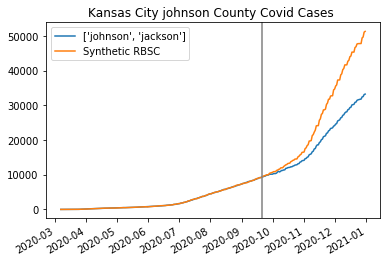

In [8]:
create_synthetic_graph("Kansas City",["Johnson", "Jackson"], ["KS", "MO"], ["09/21/2020"], True, 0)

In [86]:
#Compute graphs for all combinations 

no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']
Total_prediction_data_fans = []
Total_prediction_data_no_fans = []
dropped_stadium_df = stadium_county_df.copy()
dropped_stadium_df = dropped_stadium_df[['Team', 'First date home stadium open to fans','County(s)', 'State']]
dropped_stadium_df = dropped_stadium_df.fillna("")
grouped_df = dropped_stadium_df.groupby('Team').agg(list)
grouped_df.reset_index(inplace=True)


#We want to manually fill in Dates for stadiums not open to fans, easier this way. 
grouped_df.loc[grouped_df['Team'] == 'Chicago', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Detroit', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Las Vegas', 'First date home stadium open to fans'] = [['9/21/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Chargers', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Rams', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Minnesota', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New England', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New Orleans', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Giants', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Jets', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'San Francisco', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Seattle', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Tennessee', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Washington', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Pittsburgh', 'First date home stadium open to fans'] = [['10/11/2020']]
grouped_df.loc[grouped_df['Team'] == 'Kansas City', 'First date home stadium open to fans'] = [['9/10/2020']] #Error in data set

In [ ]:
#dropped_stadium_df = dropped_stadium_df.drop_duplicates(subset='Team') #Only need 1 for each team
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])


for i, (team, county, state, date) in enumerate(zipped_input):

    if (team != 'Washington'):
        create_synthetic_graph(team, county, state, date, True, 0)
    else:
        create_synthetic_graph('Kansas City',["Johnson", "Jackson"] ,["MO"], ['9/10/2020'], True, 0)

In [ ]:
#Make earlier function to be able to graph weeks 1-6 before the intervention. 
no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']

def create_synthetic_lines(team_name_str, stadium_county_str, state_str, intervention_date):
    intervention_date = [x for x in intervention_date if x != ""]
    
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s
            
    intervention_date = pd.to_datetime(intervention_date)
    intervention_array = [intervention_date - datetime.timedelta(weeks=i) for i in range(0, 7)]
    print(team_name_str)
    count = 0
    for intervention in intervention_array: 
        
        intervention = intervention.strftime('%m/%d/%Y')
        l = []
        l.append(intervention)
        l.append("")
        
        create_synthetic_graph(team_name_str, stadium_county_str, state_str, l, False, count)
        
        count += 1
    plt.show()
    
    return 


In [ ]:
#Compute graphs for all combinations 

dropped_stadium_df = stadium_county_df[['Team', 'First date home stadium open to fans','County(s)', 'State']]
dropped_stadium_df = dropped_stadium_df.fillna("")
grouped_df = dropped_stadium_df.groupby('Team').agg(list)
grouped_df.reset_index(inplace=True)

#We want to manually fill in Dates for stadiums not open to fans, easier this way. 
grouped_df.loc[grouped_df['Team'] == 'Chicago', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Detroit', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Las Vegas', 'First date home stadium open to fans'] = [['9/21/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Chargers', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Rams', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Minnesota', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New England', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New Orleans', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Giants', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Jets', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'San Francisco', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Seattle', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Tennessee', 'First date home stadium open to fans'] = [['10/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Washington', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Pittsburgh', 'First date home stadium open to fans'] = [['10/11/2020']]
grouped_df.loc[grouped_df['Team'] == 'Kansas City', 'First date home stadium open to fans'] = [['9/10/2020']] #Error in data set

#dropped_stadium_df = dropped_stadium_df.drop_duplicates(subset='Team') #Only need 1 for each team
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

# for i, (team, county, state, date) in enumerate(zipped_input):
#     if (team != 'Washington'):
#         create_synthetic_graph(team, county, state, date)
    
for i, (team, county, state, date) in enumerate(zipped_input):
    if team != "Washington":
        create_synthetic_lines(team, county, state, date)
        plt.show()


In [ ]:
#create_synthetic_lines("Kansas City",["Johnson", "Jackson"], ["KS", "MO"], ["09/10/2020"])

In [ ]:
#Create graphs for results after Game day. 

#Total_prediction_data should have

print(np.array(Total_prediction_data_no_fans).shape)


assert np.array(Total_prediction_data_no_fans).shape == (14, 21) #NUmber of teams, number of days past intervention
assert np.array(Total_prediction_data_fans).shape == (17, 21)

IQR_list = []

Time_series_no_fans = np.array(Total_prediction_data_no_fans).T #Transpose of time series data
Time_series_fans = np.array(Total_prediction_data_fans).T

# q1, q3 = np.percentile(Time_series, [25, 75], axis=1)
# iqr = q3 - q1

# print(q1)
# print(q3)

#plt.fill_betweenx(np.arange(len(iqr)), q1, q3, color='b', alpha=0.2)
fig, ax = plt.subplots()

plt.boxplot(Time_series_no_fans.T, vert=True, showfliers = False)
ax.set_ylim(bottom=-0.3,top = 0.3)
plt.xlabel("Days after Intervention")
plt.ylabel("Relative Difference Delta")
plt.title("Days after Intervention Delta for Stadium with No Fans")
ax.axhline(0, color='grey', linestyle='--')

# Show the plot
plt.show()

fig,ax = plt.subplots()

plt.boxplot(Time_series_fans.T, vert=True, showfliers = False)
ax.set_ylim(bottom=-0.3,top=0.3)

plt.xlabel("Days after Intervention")
plt.ylabel("Relative Difference Delta")
plt.title("Days after Intervention Delta for Stadium with Fans")
ax.axhline(0, color='grey', linestyle='--')
plt.show()
    

In [9]:
#MCMC Bayesian factor Synthetic Control

#Donors and Target. Key idea in Synthetic control is to learn some model to predict the values in target based on donors.

#Original method proves that you can caputre causal effects only if it's linear. 

#What we're trying to show is that a general model applies. 

#Draft that is a mess right now. 

#Stat 348. 

#Knowing Z gives me all the information about Y. 

#Probabilistic version of PCA

#Find a factor model, poisson factor. MCMC bayesian inference. 

#familiarize with PYRO, probabilistic programming framework. 

#Want to compute posterior given what you observe. Usually, the denominator you don't know how to compute. 

#So you have to approximate that integral. MCMC samples from the posterior. 

#Bayesian factor model generative story for the data, then gain back sample from the posterior. 

#Search through space of models efficiently, specify generative model and then get back posterior sample. 

#Alternative to PYRO is implementation, find alternative to probabilistic PCA and bayesian poisson factorization. 

#Probabilistic PCA bayesian, and poisson factorization samples of the posterior, apply it to dataset. 

#And then we will see how to check the models. 

#You are going to implement a function that can generate samples of data. Function represents hypothesis on how the dataset 
#Probabilistic generative for your data. Now give me a datset and I will sample from the posterior distribution from that data. 

In [132]:
#Sample Cincinnati Data. 

import pyro
import pyro.distributions as dist
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.infer.mcmc as mcmc

#Below function gets training X and training Y data for applying Bayesian Model 
def get_training_data(team_name_str, stadium_county_str, state_str, intervention_date, show_plot, week):

    stadium_county_str = [x for x in stadium_county_str if x != ""]
    state_str = [x for x in state_str if x != ""]
    intervention_date = [x for x in intervention_date if x != ""]
    
    #Convert to lower case to avoid case insensitivity later
    stadium_county_str = [s.lower() for s in stadium_county_str]
    #To find intervention_date, we want first entry that has numbers, since some in data is text only.
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s

    intervention_date = pd.to_datetime(intervention_date)
    

    #Convert State Acronym to full state name
    for state in range(len(state_str)):
        if state_str[state] in home_state_dict:
            state_str[state] = home_state_dict[state_str[state]]
            
    #Find Synthetic Counties
    synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == team_name_str]['Donor_Counties'])[0].copy()
    synthetic_counties = [s.lower() for s in synthetic_counties]
    n_donors = len(synthetic_counties)
    
    print(stadium_county_str)
    #Find Dataframe of X and Y data
    #Special case where 
    if team_name_str == 'Washington':
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str)) | ((county_covid['county'].isin(synthetic_counties)) & (county_covid['state'] == 'Maryland'))]
    else:
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str) | (county_covid['county'].isin(synthetic_counties))) & (county_covid['state'].isin(state_str))]
    
    stadium_county_data = stadium_county_data.fillna(method='bfill')
    stadium_county_data['date'] = pd.to_datetime(stadium_county_data['date'], infer_datetime_format=True)
    
    earliest_date = list(stadium_county_data.loc[stadium_county_data['county'].isin(stadium_county_str)]['date'])[0]
    
    #Start training from the earliest date of when our stadium county data becomes available.
    stadium_county_data = stadium_county_data.loc[stadium_county_data['date'] >= earliest_date]
    
    #Total Pivot is pivot table cases for entire dataset, training pivot is the same but for < intervention date
    total_pivot = stadium_county_data.pivot_table(columns='county', values='cases', index= 'date').reset_index()
    total_pivot = total_pivot.loc[total_pivot['date'] >= earliest_date]
    
    #Sum up stadium counties for our prediction. 
    total_pivot['Stadium_County'] = total_pivot.apply(lambda row: row[stadium_county_str].sum(), axis=1)
    #total_pivot['Stadium_County'] = total_pivot.loc[:, total_pivot.columns == (stadium_county_str[0])]
    
    total_pivot.drop(stadium_county_str, axis=1, inplace=True)
    
    total_pivot.fillna(0, inplace=True)
    
    training_pivot = total_pivot.loc[total_pivot['date'] < intervention_date]
    
    training_dates = training_pivot['date']
    
    total_dates = total_pivot['date']
    
    training_pivot = training_pivot.drop(['date'], axis=1)
    
    total_pivot = total_pivot.drop(['date'], axis=1)
    
    X_train = training_pivot.loc[:, ~training_pivot.columns.isin(['Stadium_County'])]
    
    Y_train = training_pivot['Stadium_County']
    
    total_X = total_pivot.loc[:, ~total_pivot.columns.isin(['Stadium_County'])]
    total_Y = total_pivot['Stadium_County']

    return X_train, Y_train, total_X, total_Y, total_dates

x_train, y_train, x_test, y_test, dates = get_training_data('Cincinnati',["Hamilton"] ,["OH"], ['10/04/2020'], True, 0)

dummy_train_x, dummy_train_y = torch.tensor(x_train.values), torch.tensor(y_train.values)

dummy_test_x, dummy_test_y = torch.tensor(x_test.values), torch.tensor(y_test.values)



['hamilton']


In [133]:
#Import bayesian PCA

import pyro
import pyro.distributions as dist
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.infer.mcmc as mcmc

def bayesian_pca(data, latent_dim, mask): #Pass in mask directly into the model 
    # Define model parameters
    n, p = data.shape
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mu = torch.zeros(p)
    covariance = sigma * torch.eye(p)
    

#     Z_nl = pyro.sample("Z", dist.MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim)).expand((n,)).to_event(1))
    
#     W_lp = pyro.sample("W", dist.MultivariateNormal(torch.zeros(p), torch.eye(p)).expand((latent_dim,)).to_event(1))
    Z_mean = pyro.param("Z_mean", torch.zeros(n, latent_dim))
    Z_cov = pyro.param("Z_cov", torch.eye(latent_dim))


    W_mean = pyro.param("W_mean", torch.zeros(latent_dim, p))
    W_cov = pyro.param("W_cov", torch.eye(p))
    
    
    Z_mean.data = torch.zeros(n, latent_dim)
    Z_cov.data = torch.eye(latent_dim)
    W_mean.data = torch.zeros(latent_dim, p)
    W_cov.data = torch.eye(p)

    Z_nl = pyro.sample("Z", dist.MultivariateNormal(Z_mean, Z_cov))
    W_lp = pyro.sample("W", dist.MultivariateNormal(W_mean, W_cov))
    
    mean = Z_nl @ W_lp

    # sample observed variables from a multivariate Gaussian with mean "mean" and covariance "covariance"
    
    #Implement mask on our data to avoid those probabilities. 

    X = pyro.sample("X", dist.Normal(mean, sigma).mask(mask), obs=data)
    
    
    return X


In [147]:
#dummy_train is what we are currently using to test our Bayesian Factor models. 

#Our PCA becomes 177 * 10, with last 30 * 3 Data to be masked. 

def bayesian_pca_mcmc(data):

    pyro.clear_param_store()   
    latent_dim = 9
    # Run MCMC
    num_samples = 300
    #dummy_train = np.array(dummy_train[:100])

    #Lower warmup steps for code to run
    warmup_steps = 500
    kernel = mcmc.NUTS(bayesian_pca)
    mcmc_run = mcmc.MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps)

    N, P = data.shape
    mask_rows = torch.randperm(N)[:20]
    mask_cols = torch.randperm(P)[:5]

    mask = torch.ones(N,P)

    for i in mask_rows:
        for j in mask_cols:
            mask[i,j] = 0
    random_mask = mask.bool() #Boolean Tensor for mask

    end_block_mask = torch.ones(N,P)
    end_block_mask[-30:, -3:] = 0
    end_block_mask = end_block_mask.bool()


    test_mask = torch.ones(N,P)
    test_mask = test_mask.bool()

    #Apply MCMC to our data
    mcmc_run.run(data, latent_dim, random_mask)

    pyro.clear_param_store()
    #print(dummy_train)
    
    posterior_samples = mcmc_run.get_samples()

    # Extract W, sigma, and Z samples
    W_samples = posterior_samples["W"]
    sigma_samples = posterior_samples["sigma"]
    Z_samples = posterior_samples["Z"]
    
    return W_samples, sigma_samples, Z_samples

W_samples, sigma_samples, Z_samples = bayesian_pca_mcmc(dummy_train_x)

Sample: 100%|██████████| 800/800 [40:02,  3.00s/it, step size=6.45e-03, acc. prob=0.897] 


In [157]:
N, P = dummy_train_x.shape
mask_rows = torch.randperm(N)[:20]
mask_cols = torch.randperm(P)[:5]

mask = torch.ones(N,P)

for i in mask_rows:
    for j in mask_cols:
        mask[i,j] = 0
random_mask = mask.bool() #Boolean Tensor for mask

In [149]:
#Posterior Predictive Check Bayesian PCA (Create a better function for this to handle different models)

reconstructed_X = Z_samples @ W_samples #Data_Rep Drawn from posterior Distribution


log_prob_list = []
test_prob_list = []
for w,z,sig,x in zip(W_samples, Z_samples, sigma_samples, reconstructed_X):
    #w is 2*5, z is 100*2, multiplied is 100*5. )
    #Calculate log probability that distribution 
    #Create new Y distribution based off our parameters
    mean = z@w
    #selected_mean = mean[random_mask.unsqueeze(-1)].reshape(-1, mean.shape[1])

    covariance = sig
    mean_masked = mean[random_mask]

    
    sample_dist = dist.Normal(mean_masked, sig)
    y_pred  = sample_dist.sample()
    #Calculate the likelihood given this sample
    y_pred_likelihood = sample_dist.log_prob(y_pred).sum()
    
    data_test = torch.tensor(dummy_train_x[random_mask])
    
    #Now, we want to calculate the likelihood of the actual data. 
    test_prob =sample_dist.log_prob(data_test).sum()
    
    log_prob_list.append(-1 * y_pred_likelihood) 
    test_prob_list.append(-1 * test_prob)

count = sum([1 for x, y in zip(log_prob_list, test_prob_list) if x > y])
percent_likelihood = count / len(log_prob_list)
        
print("Percentage of Test distribution more likely than Y_Pred is" + str(percent_likelihood))


#Around 250 for log_prob, 1600 for test_prob. Random Mask, 1000 samples. 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Percentage of Test distribution more likely than Y_Pred is0.0


In [150]:
test_prob_list

[tensor(48969.7290, dtype=torch.float64),
 tensor(49245.4846, dtype=torch.float64),
 tensor(49013.9059, dtype=torch.float64),
 tensor(48986.0143, dtype=torch.float64),
 tensor(48999.3964, dtype=torch.float64),
 tensor(49099.8710, dtype=torch.float64),
 tensor(49069.4224, dtype=torch.float64),
 tensor(49409.7596, dtype=torch.float64),
 tensor(48844.3745, dtype=torch.float64),
 tensor(48985.9806, dtype=torch.float64),
 tensor(49078.0364, dtype=torch.float64),
 tensor(49020.3628, dtype=torch.float64),
 tensor(49147.7393, dtype=torch.float64),
 tensor(49168.2607, dtype=torch.float64),
 tensor(49413.1137, dtype=torch.float64),
 tensor(49194.7748, dtype=torch.float64),
 tensor(49200.7016, dtype=torch.float64),
 tensor(49139.4275, dtype=torch.float64),
 tensor(49061.3615, dtype=torch.float64),
 tensor(49025.0353, dtype=torch.float64),
 tensor(49156.0368, dtype=torch.float64),
 tensor(49013.1919, dtype=torch.float64),
 tensor(49042.2486, dtype=torch.float64),
 tensor(48979.8518, dtype=torch.fl

In [151]:
log_prob_list

[tensor(48104.7293, dtype=torch.float64),
 tensor(48138.8957, dtype=torch.float64),
 tensor(48270.4002, dtype=torch.float64),
 tensor(48138.0196, dtype=torch.float64),
 tensor(48240.7419, dtype=torch.float64),
 tensor(48263.7406, dtype=torch.float64),
 tensor(48149.3961, dtype=torch.float64),
 tensor(48385.9973, dtype=torch.float64),
 tensor(48393.6541, dtype=torch.float64),
 tensor(48327.0645, dtype=torch.float64),
 tensor(48318.6626, dtype=torch.float64),
 tensor(48352.7377, dtype=torch.float64),
 tensor(48278.2580, dtype=torch.float64),
 tensor(48152.9823, dtype=torch.float64),
 tensor(48428.6206, dtype=torch.float64),
 tensor(48055.5185, dtype=torch.float64),
 tensor(48205.7373, dtype=torch.float64),
 tensor(48327.4442, dtype=torch.float64),
 tensor(48429.6506, dtype=torch.float64),
 tensor(48330.9700, dtype=torch.float64),
 tensor(48321.8332, dtype=torch.float64),
 tensor(48132.9547, dtype=torch.float64),
 tensor(48264.3642, dtype=torch.float64),
 tensor(48459.1338, dtype=torch.fl

In [154]:
####POISSON FACTORIZATION EXAMPLE

def poisson_factorization(data, latent_dim, mask):
    # Define model parameters
    n, p = data.shape
    
    #Construct samples of F, G, and X. X is assumed to be poisson distribution of F * G
    F = pyro.sample("F", dist.Gamma(1., 1.).expand([n, latent_dim]))
    G = pyro.sample("G", dist.Gamma(1., 1.).expand([latent_dim, p]))
    

    #use our mask to mask data

    #Implement mask on our data to avoid those probabilities. 
    with pyro.poutine.mask(mask=mask):
        X = pyro.sample("X", dist.Poisson(F @ G), obs=data)
    
    return X

# Define model

def poisson_mcmc(latent_dim, training_data, warmup_steps, samples, mask_type="Random"): #Default masking type is Random
    #Runs MCMC on the poisson model, returns F and G Samples

    #Is our latent dimension here also deterined as a hyperparameter? 
    model = poisson_factorization


    #Create mask for training/testing purposes
    N, P = dummy_train.shape
    
    if mask_type == "Random":
        mask_rows = torch.randperm(N)[:20]
        mask_cols = torch.randperm(P)[:5]

        mask = torch.ones(N,P)

        for i in mask_rows:
            for j in mask_cols:
                mask[i,j] = 0

        mask = mask.bool() #Random column and rows mask
        
    elif mask_type == "End":

        #TEST END BLOCK MASK
        end_block_mask = torch.ones(N,P)
        end_block_mask[-30:, -3:] = 0
        mask = end_block_mask.bool()
    else:
        print("Invalid Mask")
        return

    # Run MCMC
    kernel = mcmc.NUTS(model)
    mcmc_run = mcmc.MCMC(kernel, num_samples=samples, warmup_steps=warmup_steps)

    #Run MCMC process on our data with given Latent dimension
    mcmc_run.run(training_data, latent_dim, mask)
    
    posterior_samples = mcmc_run.get_samples()

    # Extract F, G, lambda_f, and lambda_g samples
    F_samples = posterior_samples["F"]
    G_samples = posterior_samples["G"]
    
    return F_samples, G_samples
    

In [155]:
F_samples, G_samples = poisson_mcmc(10, dummy_train_x, 500, 500)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Sample: 100%|██████████| 1000/1000 [05:39,  2.95it/s, step size=5.23e-02, acc. prob=0.859]


In [164]:
#Posterior Predictive Check

reconstructed_X = F_samples @ G_samples #Data_Rep Drawn from posterior Distribution
log_prob = []
test_prob_list = []

for f,g in zip(F_samples, G_samples):
    
    #NEED TO CHECK IF THIS WAY OF MASKING VALUES INTERFERE WITH JOINT PROBABILITY DISTRIBUTION ! 
    
    #Create new Y distribution based off our parameters, only masked values
    mu = f @ g
    testing_mu = torch.tensor(mu[random_mask])
    
    sample_dist = dist.Poisson(testing_mu)
    
    #Only have prediction on selected mask_rows and mask_cols
    y_pred  = sample_dist.sample()
    
    #Calculate the likelihood given this sample
    y_pred_likelihood = sample_dist.log_prob(y_pred).sum()
    
    #print(y_pred_likelihood)
    
    #Now, we want to calculate the likelihood of the actual data. 
    data_test = torch.tensor(dummy_train_x[random_mask])
    
    test_prob = sample_dist.log_prob(data_test).sum()

    
    log_prob.append(-1 * y_pred_likelihood) 
    test_prob_list.append(-1 * test_prob)


count = sum([1 for x, y in zip(log_prob, test_prob_list) if x > y]) #Count is if sample > data. 
percent_likelihood = count / len(log_prob)
        
print("Percentage of Test distribution more likely than Y_Pred is" + str(percent_likelihood))
        
#Look at mean rather than sum of likelihoods
#Look into just Posterior predictive checks. 
#negative likelihood
#Different Masking schemes. Completely at random, small blocks in middle. Different sized rectangular blocks, horizontal ?
# Negative Binomial(r,p) Rij is what i'm going to factorize(turn into z * w), pij is equal to a constant. 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Percentage of Test distribution more likely than Y_Pred is1.0


In [167]:
F_samples.size()
#G_samples.size()

torch.Size([500, 199, 10])

In [160]:
#General Population Predictive Check function

def population_predictive_check(reconstructed_mean, mask, data, model, variance): #Model Refers to PCA, Poisson, Etc
    log_prob = []
    test_prob_list = []

    for mean in reconstructed_mean:
        testing_mean = torch.tensor(mean[mask])
        
        if (model == 'Poisson'):
            sample_dist = dist.Poisson(testing_mean)
            
        elif (model == 'PCA'):
            sample_dist = dist.Normal(testing_mean, variance)
        
        else:
            print("Invalid model choice")
            return

        #Only have prediction on selected mask_rows and mask_cols
        y_pred  = sample_dist.sample()

        #Calculate the likelihood given this sample
        y_pred_likelihood = sample_dist.log_prob(y_pred).sum()

        #Now, we want to calculate the likelihood of the actual data. 
        data_test = torch.tensor(data[end_block_mask])

        test_prob = sample_dist.log_prob(data_test).sum()

        log_prob.append(-1 * y_pred_likelihood) 
        test_prob_list.append(-1 * test_prob)


    count = sum([1 for x, y in zip(log_prob, test_prob_list) if x > y]) #Count is if sample > data. 
    percent_likelihood = count / len(log_prob)

    print("Percentage of Test distribution more likely than Y_Pred is" + str(percent_likelihood))
    return percent_likelihood
    
    
#General Posterior Predictive Check Method(No Mask)

def posterior_predictive_check(reconstructed_mean, data, model, variance=None): #Model Refers to PCA, Poisson, Etc
    log_prob = []
    test_prob_list = []

    for mean in reconstructed_mean:
        if (model == 'Poisson'):
            sample_dist = dist.Poisson(mean)
            
        elif (model == 'PCA'):
            sample_dist = dist.Normal(mean, variance)
        
        else:
            print("Invalid model choice")
            return

        #Only have prediction on selected mask_rows and mask_cols
        y_pred  = sample_dist.sample()

        #Calculate the likelihood given this sample
        y_pred_likelihood = sample_dist.log_prob(y_pred).sum()

        #Now, we want to calculate the likelihood of the actual data. 
        data_test = torch.tensor(data)

        test_prob = sample_dist.log_prob(data_test).sum()

        log_prob.append(-1 * y_pred_likelihood) 
        test_prob_list.append(-1 * test_prob)


    count = sum([1 for x, y in zip(log_prob, test_prob_list) if x > y]) #Count is if sample > data. 
    percent_likelihood = count / len(log_prob)

    print("Percentage of Test distribution more likely than Y_Pred is" + str(percent_likelihood))
    return percent_likelihood, log_prob, test_prob_list
    

    

In [78]:
posterior_samples = mcmc_run.get_samples()

# Extract W, sigma, and Z samples
W_samples = posterior_samples["W"]
sigma_samples = posterior_samples["sigma"]
Z_samples = posterior_samples["Z"]

W_mean = W_samples.mean(dim=0)
Z_mean = Z_samples.mean(dim=0)

reconstructed_X = Z_samples @ W_samples
p_value, sample_probs, test_probs = posterior_predictive_check(reconstructed_X, dummy_train, 'PCA', sigma_samples[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Percentage of Test distribution more likely than Y_Pred is0.592


In [173]:
#After posterior checks, aim to reconstruct Synthetic Control Method. 
from sklearn.linear_model import LinearRegression
def PCA_synthetic_control(W_mean, donor_train, stadium_train, donor_test, stadium_test, dates):
    #W_Samples should be size latent_dim * p
    #Donor_data should be size n*p 
    #Stadium_data should be size n*1
    
    pca_train_n_latent = donor_train @ W_mean.T #This is our latent variable, which we then regress for stadium
    
    lin_reg = LinearRegression().fit(pca_train_n_latent, stadium_train)
    
    pca_test_n_latent = donor_test @ W_mean.T
    
    synthetic_control = np.dot(pca_test_n_latent, lin_reg.coef_)
    
    #Plot results of synthetic control and compare with stadium_test
    
    plt.plot(dates, synthetic_control, label='Test case Bayesian PCA')
    plt.plot(dates, stadium_test, label = 'Stadium Data')
    plt.legend()
    plt.show()
    
    return synthetic_control

def Poisson_synthetic_control(G_mean, donor_train, stadium_train, donor_test, stadium_test, dates):
    
    poisson_train_n_latent = donor_train @ G_mean.T
    
    lin_reg = LinearRegression().fit(poisson_train_n_latent, stadium_train)
    
    poisson_test = donor_test @ G_mean.T
    
    synthetic_control = np.dot(poisson_test, lin_reg.coef_)
    
    
    plt.plot(dates, stadium_test, label = 'Stadium Data')
    plt.plot(dates, synthetic_control, label='Test case Bayesian PCA')
    plt.title('Cincinnati Poisson SC')
    plt.legend()
    plt.show()
    
    return synthetic_control
    
    



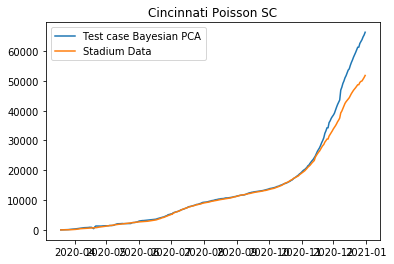

array([1.15577874e+01, 1.12060004e+01, 4.38506440e+01, 5.57036529e+01,
       6.77074378e+01, 9.08200691e+01, 9.78390799e+01, 1.07861377e+02,
       1.59018772e+02, 1.94787056e+02, 2.24954626e+02, 2.50931359e+02,
       2.90638028e+02, 3.33280180e+02, 3.55949812e+02, 4.06620427e+02,
       4.62145416e+02, 4.99719545e+02, 5.77265065e+02, 6.20585794e+02,
       6.59151964e+02, 7.12546566e+02, 7.45750589e+02, 7.57362644e+02,
       7.85997791e+02, 8.13326957e+02, 8.18268280e+02, 8.82601743e+02,
       8.75204363e+02, 8.72957621e+02, 6.41580384e+02, 4.24396627e+02,
       9.90979518e+02, 1.30510209e+03, 1.31595579e+03, 1.29796459e+03,
       1.28348939e+03, 1.28333506e+03, 1.28341949e+03, 1.33713692e+03,
       1.35915071e+03, 1.38393790e+03, 1.40494322e+03, 1.38138250e+03,
       1.38964802e+03, 1.40588400e+03, 1.49489676e+03, 1.47309617e+03,
       1.46885465e+03, 1.51976010e+03, 1.55890394e+03, 1.78701999e+03,
       1.88191753e+03, 2.02394620e+03, 2.07487487e+03, 2.07894191e+03,
      

In [172]:
#PCA_synthetic_control(W_mean, dummy_train_x, dummy_train_y, dummy_test_x, dummy_test_y, dates)
G_mean = G_samples.mean(dim=0)
Poisson_synthetic_control(G_mean, dummy_train_x, dummy_train_y, dummy_test_x, dummy_test_y, dates)

In [ ]:
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

count = 0
for i, (team, county, state, date) in enumerate(zipped_input):
    count += 1
    
    if count <= 5
        create_synthetic_graph('Kansas City',["Johnson", "Jackson"] ,["MO"], ['9/10/2020'], True, 0)
        
        